A nice property of this problem is that we can explicitly write the optimal policy of DQN with HER on the bit flipping problem:

When the state is augmented with the goal, any policy that gives 0 probability to flipping bits that are wrong, and nonzero probability to flipping bits that are true, would lead us to the goal in less than N steps. We can find which bits are true and which are wrong by simple subtraction of the 2 parts of the augmented state - the state and the goal. We can then use a Relu and another layer to get the absolute value of this difference.

Such a policy can be created using the following DQN:
* 2 layer DQN
* hidden layer's size is N*2
* bias = 0
* W1 = [I_N, -I_N; -I_N, I_N]
* W2 = [I_N, I_N]
where I_N is an identity matrix of size N.
*
Any permutation of the rows of W1 (and corresponding permutation of columns in W2) is also fine.

In this notebook, we'll train such a network, and reorder the trained weight matrices' rows/columns to see if they reconstruct the above optimal policy.

In [1]:
from functools import partial
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import torch

from src.train_dqn import epsilon_greedy_policy, DQNTrainConfig, train_dqn
from src.bfp_dqn import BFP_DQN, BFP_DQN_ModelConfig, get_env_and_model, save_output
from src.bfp_env import BFPEnvConfig, BFPRewardMethod, BFPEnv
from src.her import collect_by_policy

In [2]:
def imshow_matrices(matrices):
    n_rows = len(matrices)
    n_cols = len(matrices[0])

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes_flat = axes.flatten() if n_rows * n_cols > 1 else [axes]

    for i, matrix_tuple in enumerate(chain.from_iterable(matrices)):
        im = axes_flat[i].imshow(matrix_tuple[1])
        axes_flat[i].set_title(matrix_tuple[0])
        plt.colorbar(im, ax=axes_flat[i])

    plt.tight_layout()
    plt.show()

def get_optimal_weights(N):
    W1 = torch.cat(
        [
            torch.cat([torch.eye(N), -torch.eye(N)], dim=1),
            torch.cat([-torch.eye(N), torch.eye(N)], dim=1),
        ],
        dim=0
    )
    W2 = torch.cat([torch.eye(N), torch.eye(N)], dim=1)
    return W1, W2

def get_optimal_compatible_weights(q_network):
    """
    Reorder W1 rows by ascending order of the index of highest value in each row - this will make it as close as possible to the optimal W1.
    Then reorder W2 columns accordingly.
    """
    W1_orig = q_network.fc1.weight
    W2_orig = q_network.fc2.weight
    order = np.argmax(W1_orig.detach().numpy(), axis=1).argsort()
    W1 = W1_orig[order]
    W2 = W2_orig[:, order]
    return W1, W2

def evaluate_optimal_compatible_policy(N, train=False):
    run_name = f"N_{N}_binary_reward_HER_optimal_compatible"

    env_config = BFPEnvConfig(N=N)
    reward_method = getattr(BFPRewardMethod, env_config.reward_method)
    env = BFPEnv(env_config.N, reward_method, env_config.episode_length_factor)

    model_config = BFP_DQN_ModelConfig(hidden_dim=N*2, use_bias=False)

    # optimal model
    q_network_optimal = BFP_DQN(env_config.N, model_config.hidden_dim, use_bias=model_config.use_bias)
    W1_o, W2_o = get_optimal_weights(env_config.N)
    with torch.no_grad():
        q_network_optimal.fc1.weight.copy_(W1_o)
        q_network_optimal.fc2.weight.copy_(W2_o)

    # trained model
    if train:
        q_network_trained = BFP_DQN(env_config.N, model_config.hidden_dim, use_bias=model_config.use_bias)
        train_config = DQNTrainConfig(p_her=0.5, run_name=run_name)
        metrics = train_dqn(train_config, env, q_network_trained)
        save_output(env_config, model_config, train_config, metrics, q_network_trained)
    else:
        q_network_trained = BFP_DQN(env_config.N, model_config.hidden_dim, use_bias=model_config.use_bias)
        ckpt = torch.load('../outputs/' + run_name + '.pt', map_location="cpu")
        q_network_trained.load_state_dict(ckpt)
    W1_c, W2_c = get_optimal_compatible_weights(q_network_trained)
    with torch.no_grad():
        q_network_trained.fc1.weight.copy_(W1_c)
        q_network_trained.fc2.weight.copy_(W2_c)

    # evaluate both
    for name, q_net in [("Optimal", q_network_optimal), ("Optimal Compatible", q_network_trained)]:
        policy = partial(epsilon_greedy_policy, q_network=q_net, epsilon_model=lambda epoch: 0, epoch=0)
        evaluator = partial(collect_by_policy, env, policy, episodes_per_epoch=5)
        _, eval_metrics = evaluator()
        print(f"{name} metrics: {eval_metrics}")

    # plot
    imshow_matrices([
        [("W1 Optimal", q_network_optimal.fc1.weight.detach().numpy()), ("W2 Optimal", q_network_optimal.fc2.weight.detach().numpy())],
        [("W1 Optimal Compatible", q_network_trained.fc1.weight.detach().numpy()), ("W2 Optimal Compatible", q_network_trained.fc2.weight.detach().numpy())]
    ])


Optimal metrics: {'total_return': -1.0, 'min_dist': 0.0, 'final_dist': 0.0}
Optimal Compatible metrics: {'total_return': -1.2, 'min_dist': 0.0, 'final_dist': 0.0}


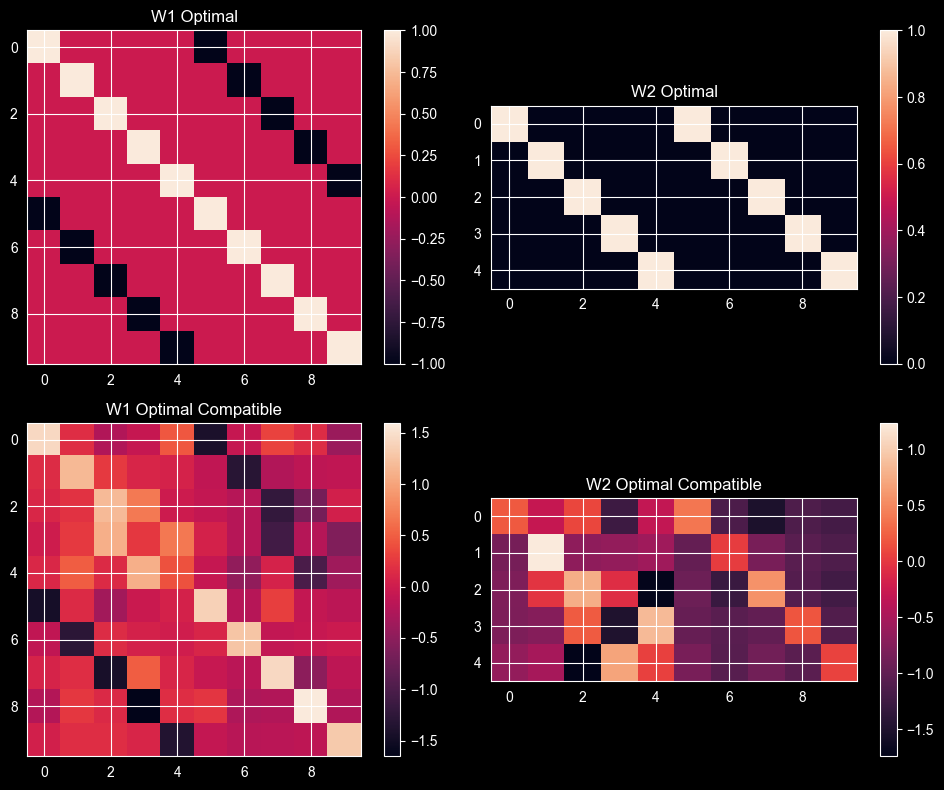

In [5]:
evaluate_optimal_compatible_policy(5)

We can see that for N=5, the HER DQN somewhat manages to reconstruct the optimal policy when the model is restricted to minimal required size.

Optimal metrics: {'total_return': -3.0, 'min_dist': 0.0, 'final_dist': 0.0}
Optimal Compatible metrics: {'total_return': -3.2, 'min_dist': 0.0, 'final_dist': 0.0}


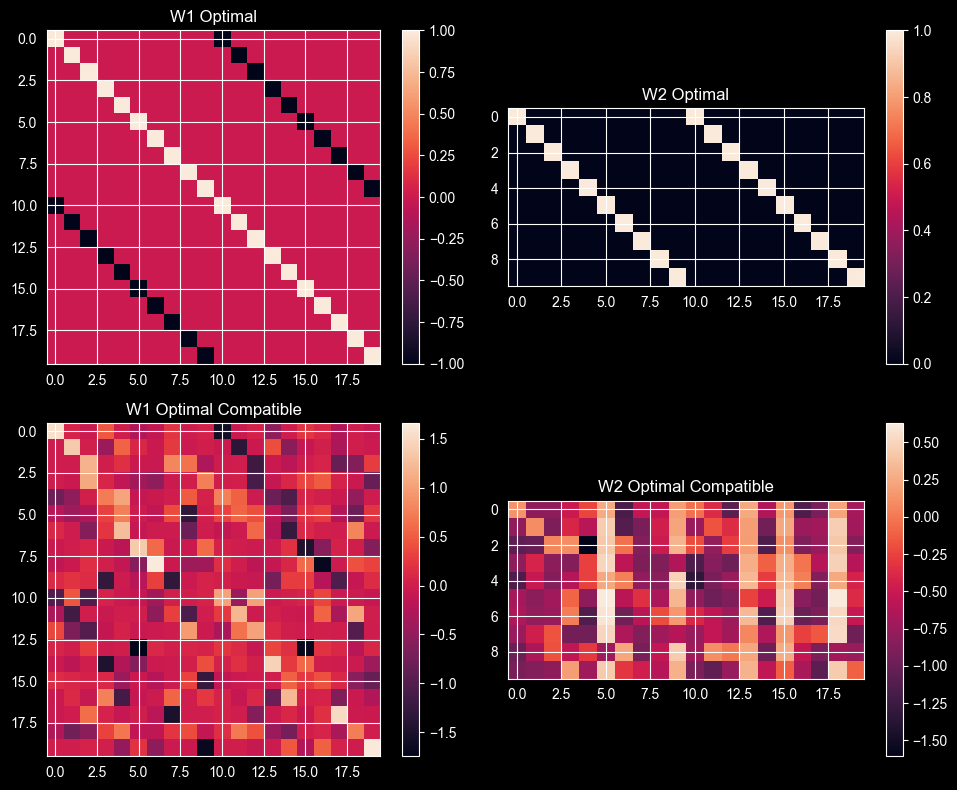

In [4]:
evaluate_optimal_compatible_policy(10)

For N=10, the model training hasn't managed to reconstruct the optimal policy.